In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [2]:
df = pd.read_csv('final_df_EDA.csv')
df.head()

,resultId,raceId,driverId,constructorId,grid,position,year,round,circuitId,date,...,driver_age,driver_experience,driver_constructor_experience,driver_points,driver_standing,constructor_points,constructor_standing,driver_wins,constructor_wins,circuit_danger
0,20323,337,4,6,3,1.0,2010,1,3,2010-03-14,...,28,140,0,0.0,0.0,0.0,0.0,0.0,0.0,0.66667
1,20324,337,13,6,2,2.0,2010,1,3,2010-03-14,...,28,116,63,0.0,0.0,0.0,0.0,0.0,0.0,0.66667
2,20325,337,1,1,4,3.0,2010,1,3,2010-03-14,...,25,52,52,0.0,0.0,0.0,0.0,0.0,0.0,0.66667
3,20326,337,20,9,1,4.0,2010,1,3,2010-03-14,...,22,43,17,0.0,0.0,0.0,0.0,0.0,0.0,0.66667
4,20327,337,3,131,5,5.0,2010,1,3,2010-03-14,...,24,70,0,0.0,0.0,0.0,0.0,0.0,0.0,0.66667


In [ ]:
load_dotenv('sql_credentials.env')

db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

db_connection_str = f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}'
engine = create_engine(db_connection_str)

results_query = """
SELECT circuitId, name, circuitRef
FROM circuits
"""
circuit_info = pd.read_sql(results_query, con=engine)
circuit_info.head()

In [ ]:
df = pd.merge(df, circuit_info[['circuitId', 'circuitRef']], on='circuitId', how='left')
df.head()

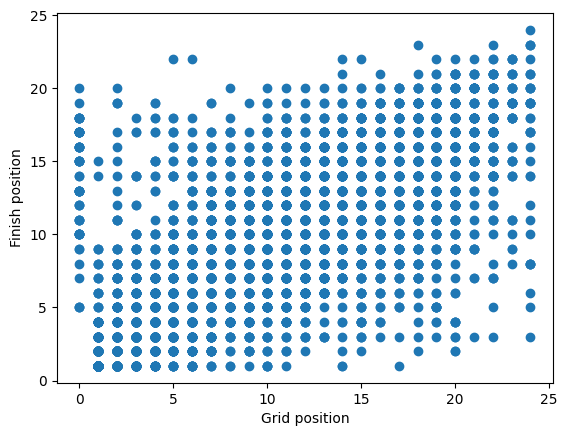

In [3]:
plt.xlabel('Grid position')
plt.ylabel('Finish position')
plt.scatter(df['grid'], df['position'])

<Axes: xlabel='Grid position', ylabel='Finish position'>

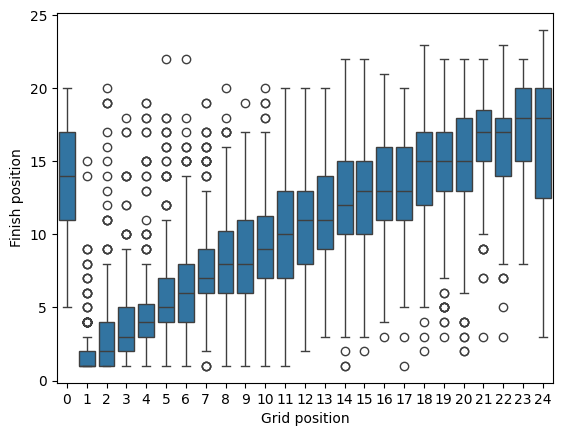

In [4]:
plt.xlabel('Grid position')
plt.ylabel('Finish position')
sns.boxplot(x='grid', y='position', data=df)

<Axes: >

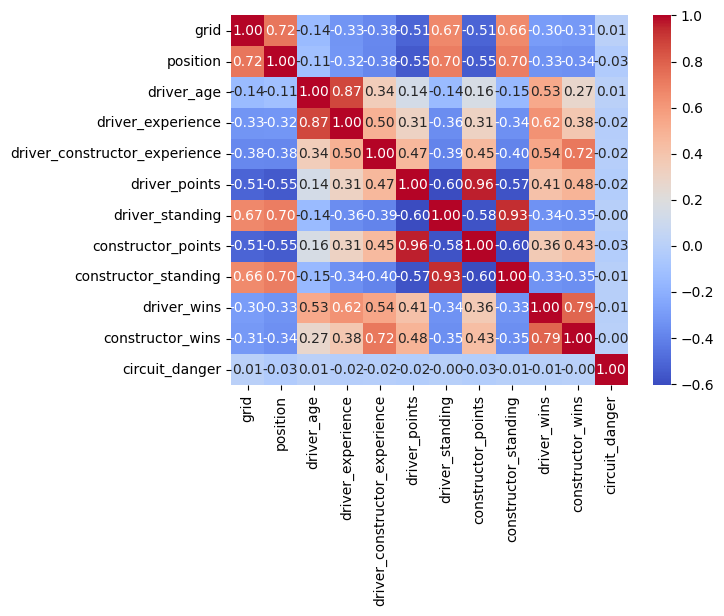

In [5]:
heatmap_data = df[['grid', 'position', 'driver_age', 'driver_experience', 'driver_constructor_experience', 
                   'driver_points', 'driver_standing', 'constructor_points', 'constructor_standing', 
                   'driver_wins', 'constructor_wins', 'circuit_danger']]

correlation_matrix = heatmap_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

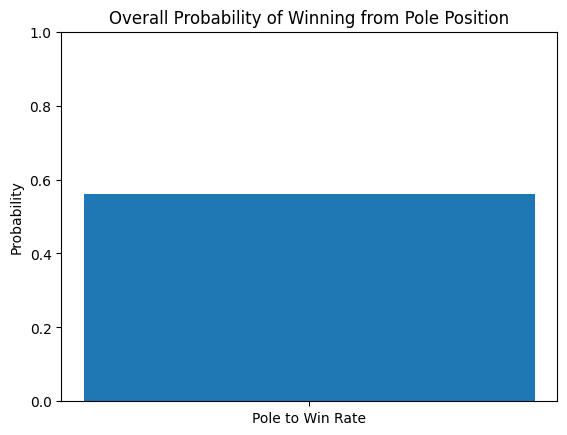

In [6]:
pole_wins = df[(df['grid'] == 1) & (df['position'] == 1)].shape[0]
total_poles = df[df['grid'] == 1].shape[0]
pole_win_rate = pole_wins / total_poles

plt.bar(['Pole to Win Rate'], [pole_win_rate])
plt.ylabel('Probability')
plt.title('Overall Probability of Winning from Pole Position')
plt.ylim(0, 1)
plt.show()

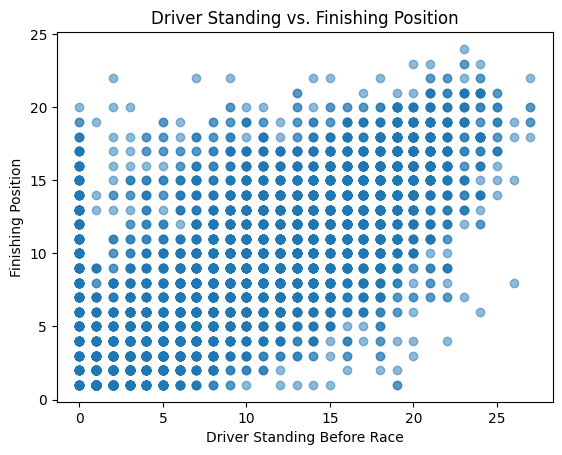

In [9]:
plt.scatter(df['driver_standing'], df['position'], alpha=0.5)
plt.title("Driver Standing vs. Finishing Position")
plt.xlabel("Driver Standing Before Race")
plt.ylabel("Finishing Position")
plt.show()

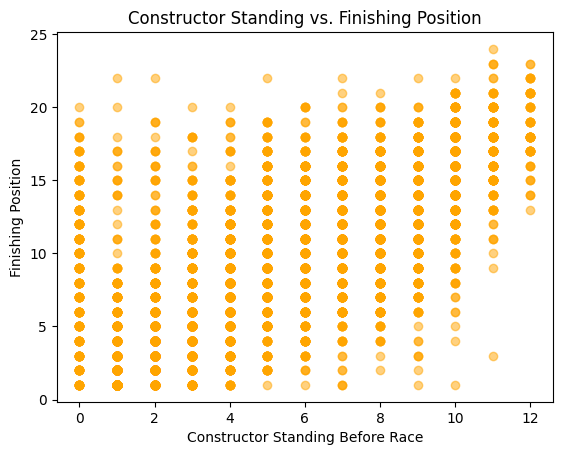

In [10]:
plt.scatter(df['constructor_standing'], df['position'], alpha=0.5, color='orange')
plt.title("Constructor Standing vs. Finishing Position")
plt.xlabel("Constructor Standing Before Race")
plt.ylabel("Finishing Position")
plt.show()

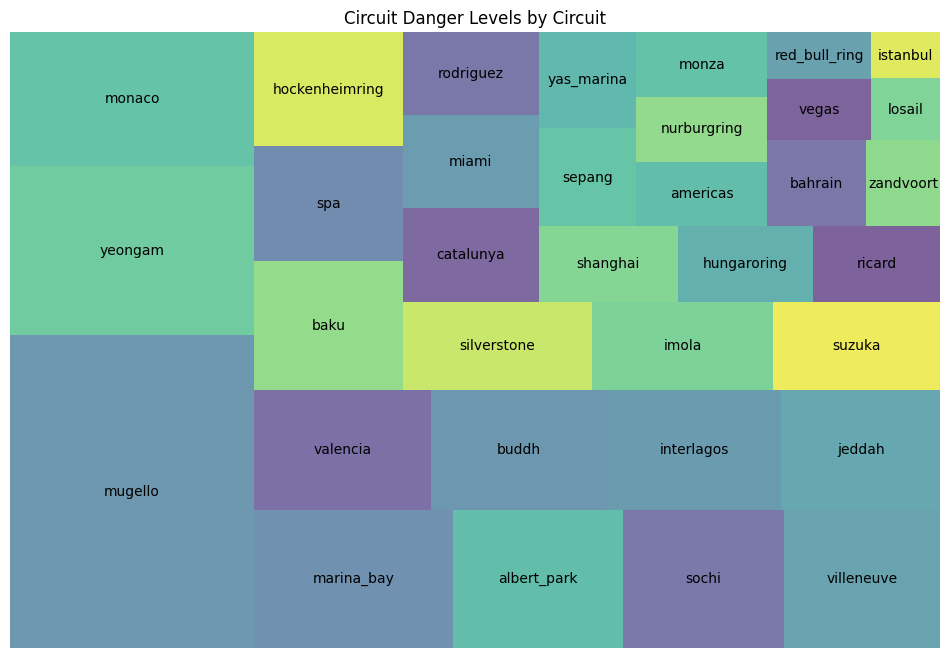

In [14]:

# Step 1: Aggregate and sort the data by circuit danger level
circuit_data = df.groupby('circuitRef', as_index=False)['circuit_danger'].mean()
circuit_data = circuit_data.sort_values(by='circuit_danger', ascending=False)  # Sort descending

# Step 2: Prepare the sizes and labels for the treemap
sizes = circuit_data['circuit_danger']
labels = circuit_data['circuitRef']

# Step 3: Plot the treemap with no padding and sorted data
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=0.7, pad=False)  # Disable padding
plt.axis('off')
plt.title('Circuit Danger Levels by Circuit')
plt.show()

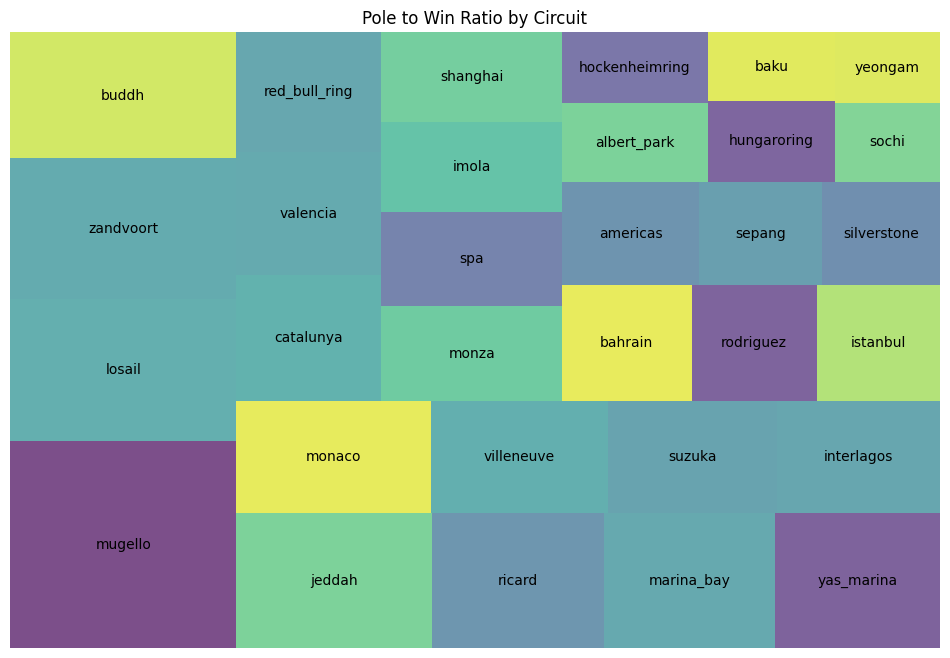

In [15]:
# Step 1: Filter data for pole position wins and calculate pole to win ratio per circuit
# Calculate total races per circuit and wins from pole position
total_races_by_circuit = df.groupby('circuitRef').size()
wins_from_pole_by_circuit = df[(df['grid'] == 1) & (df['position'] == 1)].groupby('circuitRef').size()

# Calculate the pole to win ratio
pole_to_win_ratio = (wins_from_pole_by_circuit / total_races_by_circuit).fillna(0)

# Step 2: Filter out circuits with a pole to win ratio of zero and sort by descending order
pole_to_win_ratio = pole_to_win_ratio[pole_to_win_ratio > 0].sort_values(ascending=False)

# Step 3: Prepare data for the treemap
sizes = pole_to_win_ratio.values  # The sorted pole to win ratios for rectangle sizes
labels = pole_to_win_ratio.index  # Circuit names for labels

# Step 4: Plot the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=0.7, pad=False)
plt.axis('off')
plt.title('Pole to Win Ratio by Circuit')
plt.show()

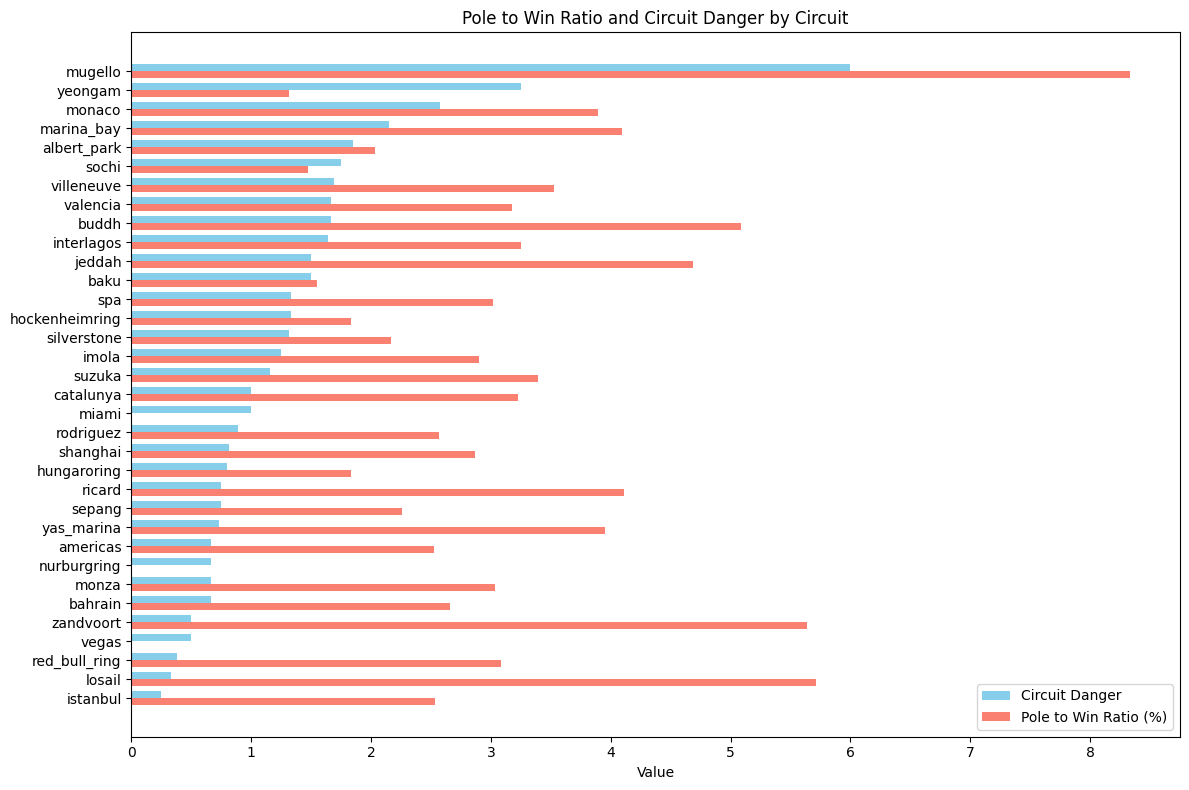

In [17]:
import numpy as np

# Step 1: Calculate circuit danger (mean) by circuit
circuit_danger = df.groupby('circuitRef')['circuit_danger'].mean()

# Step 2: Calculate pole-to-win ratio by circuit
total_races_by_circuit = df.groupby('circuitRef').size()
wins_from_pole_by_circuit = df[(df['grid'] == 1) & (df['position'] == 1)].groupby('circuitRef').size()
pole_to_win_ratio = (wins_from_pole_by_circuit / total_races_by_circuit).fillna(0) * 100  # Convert to percentage

# Step 3: Combine the data into a single DataFrame
circuit_data = pd.DataFrame({
    'circuit_danger': circuit_danger,
    'pole_to_win_ratio': pole_to_win_ratio
}).dropna().sort_values(by='circuit_danger', ascending=False)

# Step 4: Set up labels and positions
labels = circuit_data.index
circuit_danger = circuit_data['circuit_danger']
pole_to_win_ratio = circuit_data['pole_to_win_ratio']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Step 5: Plot the grouped horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(x - width / 2, circuit_danger, width, label='Circuit Danger', color='skyblue')
ax.barh(x + width / 2, pole_to_win_ratio, width, label='Pole to Win Ratio (%)', color='salmon')

# Step 6: Customize the plot
ax.set_xlabel('Value')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # Highest values at the top
ax.legend()

plt.title('Pole to Win Ratio and Circuit Danger by Circuit')
plt.tight_layout()
plt.show()
